<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Train Practice

## *Data Science Unit 4 Sprint 2 Assignment 2*

Continue to use TensorFlow Keras & a sample of the [Quickdraw dataset](https://github.com/googlecreativelab/quickdraw-dataset) to build a sketch classification model. The dataset has been sampled to only 10 classes and 10000 observations per class. Please build a baseline classification model then run a few experiments with different optimizers and learning rates. 

*Don't forgot to switch to GPU on Colab!*

### Write a function to load your data

Wrap yesterday's preprocessing steps into a function that returns four items:
* X_train
* y_train
* X_test
* y_test

Your function should accept a `path` to the data as a argument.

In [3]:
!wget https://raw.githubusercontent.com/zaidalyafeai/QuickDraw10/master/quick_draw10.py

--2020-11-16 23:37:52--  https://raw.githubusercontent.com/zaidalyafeai/QuickDraw10/master/quick_draw10.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2815 (2.7K) [text/plain]
Saving to: ‘quick_draw10.py.1’

quick_draw10.py.1   100%[===================>]   2.75K  --.-KB/s    in 0s      

2020-11-16 23:37:52 (47.5 MB/s) - ‘quick_draw10.py.1’ saved [2815/2815]



In [2]:
import sys
import random
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")
import time
t_start = time.time()
%matplotlib inline

# import cv2
from sklearn.model_selection import train_test_split

from tqdm import tqdm_notebook #, tnrange
#from itertools import chain
from skimage.io import imread, imshow #, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from keras.models import Model, load_model, save_model
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add, Flatten, Dense
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam, SGD
from keras import backend as K
from keras import optimizers
import tensorflow as tf
from keras.preprocessing.image import array_to_img, img_to_array, load_img,save_img
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow import keras
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import requests
import io
from tensorflow.keras import layers
from quick_draw10 import download_and_load, plot_tsne
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import os
import glob
import numpy as np
from tensorflow.keras import layers
from quick_draw10 import download_and_load, plot_tsne
import matplotlib.pyplot as plt
import seaborn as sns


%load_ext tensorboard
logdir = os.path.join("logs", 'additional-hidden-layer')
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
X_train, y_train, X_test, y_test, class_names = download_and_load()
X_train.shape, y_train.shape, X_test.shape, y_test.shape

downloading ...
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/cloud.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/sun.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/pants.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/umbrella.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/table.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/ladder.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/eyeglasses.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/clock.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/scissors.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/cup.npy
loading ...
Training Data :  80000
Testing  Data :  20000


((80000, 28, 28), (80000,), (20000, 28, 28), (20000,))

In [4]:
class_names

['cloud',
 'sun',
 'pants',
 'umbrella',
 'table',
 'ladder',
 'eyeglasses',
 'clock',
 'scissors',
 'cup']

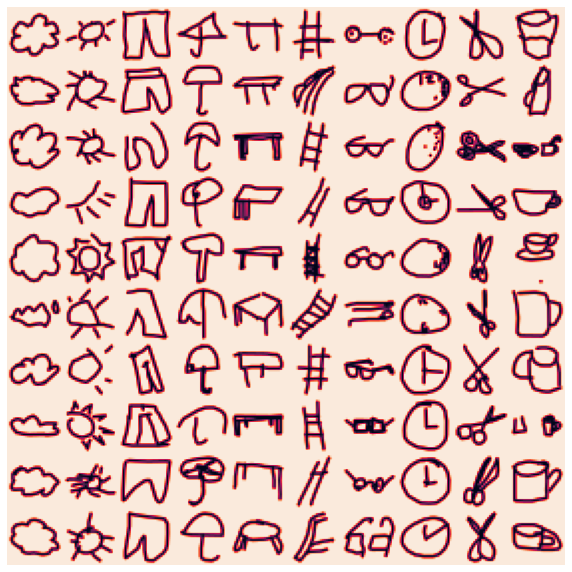

In [5]:
def visualize_classes():
  for i in range(0, 10):
    img_batch = X_train[y_train == i][0:10]
    img_batch = np.reshape(img_batch, (img_batch.shape[0]*img_batch.shape[1], img_batch.shape[2]))
    if i > 0:
      img = np.concatenate([img, img_batch], axis = 1)
    else:
      img = img_batch
  plt.figure(figsize=(10,20))
  plt.axis('off')
  plt.imshow(img)

visualize_classes()

In [6]:
plt.style.use("dark_background")

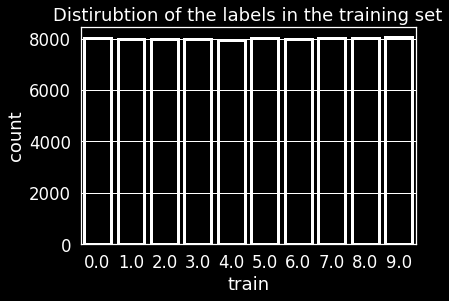

In [7]:
data = {}
data['train'] = y_train
df = pd.DataFrame.from_dict(data)
ax = sns.countplot(x = 'train', data=df, facecolor=(0, 0, 0, 0),
                   linewidth=3).set_title("Distirubtion of the labels in the training set")

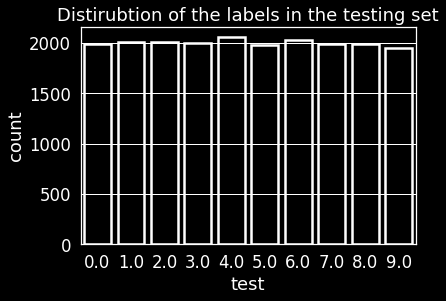

In [8]:
data = {}
data['test'] = y_test
df = pd.DataFrame.from_dict(data)
ax = sns.countplot(x = 'test', data=df, facecolor=(0, 0, 0, 0),
                   linewidth=2.5).set_title("Distirubtion of the labels in the testing set")

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


calculating tsne ...


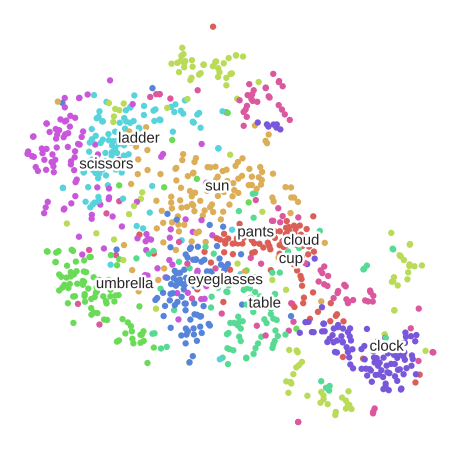

In [9]:
from yellowbrick.text import TSNEVisualizer
tsne = TSNEVisualizer()

X = np.reshape(X_train, (X_train.shape[0], 28 * 28))[0:1000]
y = y_train[0:1000]
plot_tsne(X, y)

In [10]:
# image_size = 28

# # Reshape and normalize
# X_train = X_train.reshape(X_train.shape[0], image_size, image_size, 1).astype('float32')
# X_test = X_test.reshape(X_test.shape[0], image_size, image_size, 1).astype('float32')

# X_train /= 255.0
# X_test /= 255.0

# Convert class vectors to class matrices
# y_train = keras.utils.to_categorical(y_train, len(class_names))
# y_test = keras.utils.to_categorical(y_test, len(class_names))

# X_train.shape, y_train.shape, X_test.shape, y_test.shape

### Write a Model Function
Using your model from yesterday, write a function called `create_model` which returns a compiled TensorFlow Keras Sequential Model suitable for classifying the QuickDraw-10 dataset. Include parameters for the following: 
* Learning Rate
* Optimizer

In [11]:
# # Define model
# model = keras.Sequential()

# model.add(layers.Convolution2D(16, (3, 3),
#                         padding='same',
#                         input_shape=X_train.shape[1:], activation='relu'))

# model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# model.add(layers.Convolution2D(32, (3, 3), padding='same', activation= 'relu'))

# model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# model.add(layers.Convolution2D(64, (3, 3), padding='same', activation= 'relu'))

# model.add(layers.MaxPooling2D(pool_size =(2,2)))

# model.add(layers.Flatten())

# model.add(layers.Dense(323, activation='tanh'))

# model.add(layers.Dense(len(class_names), activation='softmax')) 

# # Train model
# model.compile(loss='categorical_crossentropy',
#               optimizer="adam",
#               metrics=['accuracy'])

# print(model.summary())

In [ ]:
# Model configuration
batch_size = 50
img_width, img_height, img_num_channels = 28,28,1
loss_function = 'sparse_categorical_crossentropy'
no_classes = 10
no_epochs = 30
verbosity = 0
lr = .0001

# Determine shape of the data
input_shape = (img_width, img_height, img_num_channels)
# Parse numbers as floats
X_train = np.reshape(X_train/ 255., (X_train.shape[0], 28, 28, 1)).astype('float32')
X_test = np.reshape(X_test/255., (X_test.shape[0], 28, 28, 1)).astype('float32')

# Scale data
X_train = X_train / 255
X_test = X_test / 255

conv1 = Conv2D(64, kernel_size=(28, 28), activation='relu', input_shape=input_shape)
conv2 = Conv2D(filters = 16, kernel_size = 3, 
                           activation = tf.nn.relu, padding = 'same', name = 'conv2')
pool1 =  MaxPooling2D(pool_size = 1, name = 'pool1')
pool2 =  MaxPooling2D(pool_size = 1, name = 'pool2')

def create_model():
    opt = Adam(learning_rate=lr)
    model = Sequential([
    conv1, pool1,
    conv2, pool2,
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(10, activation='softmax')
    ])
    # compile the model
    model.compile(
        loss=loss_function,
        optimizer=opt, 
        metrics=["accuracy"]
    )
    return model
  
# initialize the model object
model = create_model()
model.summary()

my_model = model.fit(x = X_train, y = y_train, batch_size = batch_size, epochs=no_epochs)# callbacks=[tensorboard_callback])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1, 1, 64)          50240     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 1, 1, 64)          0         
_________________________________________________________________
conv2 (Conv2D)               (None, 1, 1, 16)          9232      
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 1, 1, 16)          0         
_________________________________________________________________
dense (Dense)                (None, 1, 1, 64)          1088      
_________________________________________________________________
dense_1 (Dense)              (None, 1, 1, 32)          2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1, 1, 16)          5

In [ ]:
# # initialize the model object
# # model = create_model()
# model.summary()
# my_model = model.fit(x = X_train, y = y_train, batch_size = batch_size, epochs=no_epochs)# callbacks=[tensorboard_callback])
# model.evaluate(X_test, y_test)
# score = model.evaluate(X_test, y_test, verbose=0)
# print('Test accuarcy: {:0.2f}%'.format(score[1] * 100))

<function matplotlib.pyplot.show>

### Experiment with Batch Size
* Run 5 experiments with various batch sizes of your choice. 
* Visualize the results
* Write up an analysis of the experiments and select the "best" performing model among your experiments. Make sure to compare against your model's performance yesterday. 

### Experiment with Learning Rate
* Run 5 experiments with various learning rate magnitudes: 1, .1, .01, .001, .0001.
* Use the "best" batch size from the previous experiment
* Visualize the results
* Write up an analysis of the experiments and select the "best" performing model among your experiments. Make sure to compare against the previous experiments and your model's performance yesterday. 

### Experiment with different Optimizers
* Run 5 experiments with various optimizers available in TensorFlow. See list [here](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers)
* Visualize the results
* Write up an analysis of the experiments and select the "best" performing model among your experiments. Make sure to compare against the previous experiments and your model's performance yesterday.
* Repeat the experiment combining Learning Rate and different optimizers. Does the best performing model change? 

### Additional Written Tasks

1. Describe the process of backpropagation in your own words: 
```
Your answer goes here.
```



## Stretch Goals: 

- Implement GridSearch on anyone of the experiments
- On the learning rate experiments, implement [EarlyStopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping)
- Review material on the math behind gradient descent: 

  - Gradient Descent
    - Gradient Descent, Step-by-Step  by StatQuest w/ Josh Starmer. This will help you understand the gradient descent based optimization that happens underneath the hood of neural networks. It uses a non-neural network example, which I believe is a gentler introduction. You will hear me refer to this technique as "vanilla" gradient descent. 
    - Stochastic Gradient Descent, Clearly Explained!!! by StatQuest w/ Josh Starmer. This builds on the techniques in the previous video.  This technique is the one that is actually implemented inside modern 'nets. 
These are great resources to help you understand tomorrow's material at a deeper level. I highly recommend watching these ahead of tomorrow.

  - Background Math
    - Dot products and duality by 3Blue1Brown. Explains the core linear algebra operation happening in today's perceptron.
The paradox of the derivative by 3Blue1Brown. Does a great job explaining a derivative. 
    - Visualizing the chain rule and product rule by 3Blue1Brown. Explains the black magic that happens within Stochastic Gradient Descent. 
These math resources are very much optional. They can be very heady, but I encourage you to explore. Your understanding of neural networks will greatly increase if you understand this math background.




In [ ]:
# from keras.callbacks import Callback
# import keras.backend as K
# import numpy as np
# class SGDRScheduler(Callback):
#     '''Cosine annealing learning rate scheduler with periodic restarts.
#     # Usage
#         ```python
#             schedule = SGDRScheduler(min_lr=1e-5,
#                                      max_lr=1e-2,
#                                      steps_per_epoch=np.ceil(epoch_size/batch_size),
#                                      lr_decay=0.9,
#                                      cycle_length=5,
#                                      mult_factor=1.5)
#             model.fit(X_train, Y_train, epochs=100, callbacks=[schedule])
#         ```
#     # Arguments
#         min_lr: The lower bound of the learning rate range for the experiment.
#         max_lr: The upper bound of the learning rate range for the experiment.
#         steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
#         lr_decay: Reduce the max_lr after the completion of each cycle.
#                   Ex. To reduce the max_lr by 20% after each cycle, set this value to 0.8.
#         cycle_length: Initial number of epochs in a cycle.
#         mult_factor: Scale epochs_to_restart after each full cycle completion.
#     # References
#         Blog post: jeremyjordan.me/nn-learning-rate
#         Original paper: http://arxiv.org/abs/1608.03983
#     '''
#     def __init__(self,
#                  min_lr,
#                  max_lr,
#                  steps_per_epoch,
#                  lr_decay=1,
#                  cycle_length=10,
#                  mult_factor=2):
#         self.min_lr = min_lr
#         self.max_lr = max_lr
#         self.lr_decay = lr_decay
#         self.batch_since_restart = 0
#         self.next_restart = cycle_length
#         self.steps_per_epoch = steps_per_epoch
#         self.cycle_length = cycle_length
#         self.mult_factor = mult_factor
#         self.history = {}
#     def clr(self):
#         '''Calculate the learning rate.'''
#         fraction_to_restart = self.batch_since_restart / (self.steps_per_epoch * self.cycle_length)
#         lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + np.cos(fraction_to_restart * np.pi))
#         return lr
#     def on_train_begin(self, logs={}):
#         '''Initialize the learning rate to the minimum value at the start of training.'''
#         logs = logs or {}
#         K.set_value(self.model.optimizer.lr, self.max_lr)
#     def on_batch_end(self, batch, logs={}):
#         '''Record previous batch statistics and update the learning rate.'''
#         logs = logs or {}
#         self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
#         for k, v in logs.items():
#             self.history.setdefault(k, []).append(v)
#         self.batch_since_restart += 1
#         K.set_value(self.model.optimizer.lr, self.clr())
#     def on_epoch_end(self, epoch, logs={}):
#         '''Check for end of current cycle, apply restarts when necessary.'''
#         if epoch + 1 == self.next_restart:
#             self.batch_since_restart = 0
#             self.cycle_length = np.ceil(self.cycle_length * self.mult_factor)
#             self.next_restart += self.cycle_length
#             self.max_lr *= self.lr_decay
#             self.best_weights = self.model.get_weights()
#     def on_train_end(self, logs={}):
#         '''Set weights to the values from the end of the most recent cycle for best performance.'''
#         self.model.set_weights(self.best_weights)

In [ ]:
# from keras.callbacks import Callback
# import matplotlib.pyplot as plt

# class LRFinder(Callback):
    
#     '''
#     A simple callback for finding the optimal learning rate range for your model + dataset. 
    
#     # Usage
#         ```python
#             lr_finder = LRFinder(min_lr=1e-5, 
#                                  max_lr=1e-2, 
#                                  steps_per_epoch=np.ceil(epoch_size/batch_size), 
#                                  epochs=3)
#             model.fit(X_train, Y_train, callbacks=[lr_finder])
            
#             lr_finder.plot_loss()
#         ```
    
#     # Arguments
#         min_lr: The lower bound of the learning rate range for the experiment.
#         max_lr: The upper bound of the learning rate range for the experiment.
#         steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
#         epochs: Number of epochs to run experiment. Usually between 2 and 4 epochs is sufficient. 
        
#     # References
#         Blog post: jeremyjordan.me/nn-learning-rate
#         Original paper: https://arxiv.org/abs/1506.01186
#     '''

#     def __init__(self, min_lr=1e-5, max_lr=1e-2, steps_per_epoch=None, epochs=None):
#         super().__init__()
        
#         self.min_lr = min_lr
#         self.max_lr = max_lr
#         self.total_iterations = steps_per_epoch * epochs
#         self.iteration = 0
#         self.history = {}
        
#     def clr(self):
#         '''Calculate the learning rate.'''
#         x = self.iteration / self.total_iterations 
#         return self.min_lr + (self.max_lr-self.min_lr) * x
        
#     def on_train_begin(self, logs=None):
#         '''Initialize the learning rate to the minimum value at the start of training.'''
#         logs = logs or {}
#         K.set_value(self.model.optimizer.lr, self.min_lr)
        
#     def on_batch_end(self, epoch, logs=None):
#         '''Record previous batch statistics and update the learning rate.'''
#         logs = logs or {}
#         self.iteration += 1

#         self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
#         self.history.setdefault('iterations', []).append(self.iteration)

#         for k, v in logs.items():
#             self.history.setdefault(k, []).append(v)
            
#         K.set_value(self.model.optimizer.lr, self.clr())
    
#     def plot_lr(self):
#         '''Helper function to quickly inspect the learning rate schedule.'''
#         plt.plot(self.history['iterations'], self.history['lr'])
#         plt.yscale('log')
#         plt.xlabel('Iteration')
#         plt.ylabel('Learning rate')
        
#     def plot_loss(self):
#         '''Helper function to quickly observe the learning rate experiment results.'''
#         plt.plot(self.history['lr'], self.history['loss'])
#         plt.xscale('log')
#         plt.xlabel('Learning rate')
#         plt.ylabel('Loss')